In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd 'drive/My Drive/Siamese/Speaker/Time'

/content/drive/My Drive/Siamese/Speaker/Time


In [ ]:
import sys
sys.path.insert(0, '..')
sys.path.insert(0, '../../Data')
sys.path.insert(0, '../../Encoder/Time')
sys.path.insert(0, '../../Encoder/Freq')
sys.path.insert(0, '../../Encoder')
sys.path.insert(0, '../../Conference')
sys.path.insert(0, '../../Place')

In [ ]:
!pip install torchvision==0.5.0
!pip install torchaudio==0.4.0

     |████████████████████████████████| 4.0MB 2.8MB/s 
     |████████████████████████████████| 753.4MB 20kB/s 
  Found existing installation: torch 1.5.1+cu101
    Uninstalling torch-1.5.1+cu101:
      Successfully uninstalled torch-1.5.1+cu101
  Found existing installation: torchvision 0.6.1+cu101
    Uninstalling torchvision-0.6.1+cu101:
      Successfully uninstalled torchvision-0.6.1+cu101
     |████████████████████████████████| 3.1MB 2.8MB/s 


In [ ]:
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [ ]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm

In [ ]:
DATASET_PATH = '/content/drive/My Drive/DataSet'
EPOCH_NUM = 10
SPEAKERS_NUM = 20

torch.backends.cudnn.deterministic = True

NUM_WORKERS = 4

In [ ]:
from IdentificationDataset import IdentificationDataset
from IdentificationDataset import ReturnType

from torchvision.transforms import Compose
from Normalize import Normalize
from ToTensor import ToTensor

DATASET_PATH = '/content/drive/My Drive/DataSet'

transforms = Compose([
    Normalize(),
    ToTensor()
])

testset = IdentificationDataset(DATASET_PATH, 
                                SPEAKERS_NUM,
                                train=False, 
                                transform=transforms,
                                lenght=3,
                                return_type=ReturnType.STANDARD)
testsetloader = torch.utils.data.DataLoader(testset, 
                                            batch_size=1, 
                                            num_workers=NUM_WORKERS)

print("lenght test loader ", len(testsetloader))


sample lenght  3
lenght test loader  2134


In [ ]:
from Conference import Conference

# Define default device, we should use the GPU (cuda) if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)
net = Conference(DEVICE,
                 avg=False,
                 time=True)

net.load_encoder(size=3)
net.to(DEVICE)

cuda
Encoder loaded


Conference(
  (encoder): Time(
    (block0): Conv1DBlock(
      (conv): Conv1d(1, 16, kernel_size=(9,), stride=(2,))
      (acti): ReLU()
      (bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (maxpool): MaxPool1d(kernel_size=9, stride=8, padding=0, dilation=1, ceil_mode=False)
    )
    (block1): Conv1DBlock(
      (conv): Conv1d(16, 128, kernel_size=(9,), stride=(2,))
      (acti): ReLU()
      (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (maxpool): MaxPool1d(kernel_size=9, stride=4, padding=0, dilation=1, ceil_mode=False)
    )
    (block2): Conv1DBlock(
      (conv): Conv1d(128, 256, kernel_size=(9,), stride=(2,))
      (acti): ReLU()
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (maxpool): MaxPool1d(kernel_size=9, stride=4, padding=0, dilation=1, ceil_mode=False)
    )
    (block3): Conv1DBlock(
      (conv1): Conv1d(256, 64, kernel_size=(

In [ ]:
with torch.no_grad():
  # test
  net.eval()
  # Store the speakers
  speakers_list = testset.get_speakers_list(20)
  net.initspeakers(speakers_list)  
  net.initplaces(speakers_list)

In [ ]:
import numpy as np

dict_error = {}
dict_nb = {}

with torch.no_grad():
  best_accuracy = 0
  mean_accuracies = []
  topk_accuracies = []
  min_accuracies = []

  for epoch_num in range(EPOCH_NUM):
    print("*** Epoch ", epoch_num, " ***")
    mean_accuracy = 0
    topk_accuracy = 0
    min_accuracy = 0
    nb_test = 0
    if epoch_num == EPOCH_NUM-1:
      print("activate stats")
      net.activatestats()

    for speaker in speakers_list:
      id = speaker[0]
      dict_error[id] = 0
      dict_nb[id] = 0

    for iter_num, (gold_label, sample) in tqdm(enumerate(testsetloader)):
      mean_label, topk_label, min_label = net(sample, gold_label)
      nb_test += 1
      gold_label = gold_label.item()
      dict_nb[gold_label] += 1

      if gold_label == mean_label:
        mean_accuracy += 1
      if gold_label == topk_label:
        topk_accuracy += 1
      else:
        dict_error[gold_label] += 1
      if gold_label == min_label:
        min_accuracy += 1

    mean_accuracy /= nb_test
    topk_accuracy /= nb_test
    min_accuracy /= nb_test
    mean_accuracies.append(mean_accuracy)
    topk_accuracies.append(topk_accuracy)
    min_accuracies.append(min_accuracy)
    print("accuracy mean ", mean_accuracy, "topk", topk_accuracy, 
          " min ", min_accuracy)
    add = 0
    nb = 0
    for id in dict_error:
      add += dict_error[id]
      nb += dict_nb[id]
      dict_error[id] =  100 * dict_error[id]//dict_nb[id] 
    print("Error ", add/nb)
    print(dict_error)

  net.store_speakers(20, 3)
  net.dumpstats()

*** Epoch  0  ***


2134it [05:35,  6.36it/s]

accuracy mean  0.29053420805998126 topk 0.4915651358950328  min  0.457825679475164
Error  0.5084348641049672
{270: 39, 272: 60, 273: 20, 274: 75, 275: 45, 276: 44, 277: 62, 278: 6, 271: 94, 279: 100, 280: 82, 281: 40, 282: 35, 283: 62, 285: 55, 284: 100, 286: 43, 287: 87, 288: 87, 289: 50}
*** Epoch  1  ***



2134it [00:33, 62.85it/s]

accuracy mean  0.4835988753514527 topk 0.5487347703842549  min  0.5131208997188379
Error  0.45126522961574506
{270: 46, 272: 68, 273: 50, 274: 68, 275: 40, 276: 35, 277: 56, 278: 6, 271: 78, 279: 95, 280: 59, 281: 46, 282: 34, 283: 33, 285: 45, 284: 52, 286: 36, 287: 72, 288: 68, 289: 41}
*** Epoch  2  ***



2134it [00:33, 62.93it/s]

accuracy mean  0.4681349578256795 topk 0.569821930646673  min  0.5346766635426429
Error  0.4301780693533271
{270: 53, 272: 56, 273: 57, 274: 61, 275: 36, 276: 44, 277: 31, 278: 10, 271: 57, 279: 79, 280: 50, 281: 44, 282: 36, 283: 33, 285: 44, 284: 23, 286: 38, 287: 58, 288: 56, 289: 43}
*** Epoch  3  ***



2134it [00:34, 62.29it/s]

accuracy mean  0.5262417994376757 topk 0.5866916588566073  min  0.5482661668228679
Error  0.4133083411433927
{270: 56, 272: 52, 273: 63, 274: 51, 275: 33, 276: 49, 277: 23, 278: 13, 271: 46, 279: 53, 280: 46, 281: 46, 282: 36, 283: 35, 285: 40, 284: 14, 286: 37, 287: 39, 288: 35, 289: 39}
*** Epoch  4  ***



2134it [00:33, 62.77it/s]

accuracy mean  0.5248359887535146 topk 0.5716963448922212  min  0.5482661668228679
Error  0.42830365510777885
{270: 48, 272: 46, 273: 66, 274: 48, 275: 36, 276: 55, 277: 31, 278: 17, 271: 46, 279: 41, 280: 46, 281: 50, 282: 39, 283: 36, 285: 43, 284: 18, 286: 40, 287: 39, 288: 43, 289: 40}
*** Epoch  5  ***



2134it [00:34, 62.70it/s]

accuracy mean  0.5187441424554826 topk 0.5609184629803187  min  0.5431115276476102
Error  0.43908153701968133
{270: 48, 272: 48, 273: 67, 274: 48, 275: 39, 276: 56, 277: 32, 278: 18, 271: 42, 279: 42, 280: 47, 281: 47, 282: 40, 283: 39, 285: 46, 284: 18, 286: 41, 287: 37, 288: 45, 289: 45}
*** Epoch  6  ***



2134it [00:34, 62.28it/s]

accuracy mean  0.5196813495782568 topk 0.5627928772258669  min  0.53514526710403
Error  0.4372071227741331
{270: 51, 272: 50, 273: 66, 274: 48, 275: 39, 276: 54, 277: 31, 278: 23, 271: 32, 279: 42, 280: 44, 281: 47, 282: 42, 283: 41, 285: 43, 284: 18, 286: 44, 287: 37, 288: 39, 289: 40}
*** Epoch  7  ***



2134it [00:34, 61.30it/s]

accuracy mean  0.5178069353327085 topk 0.5515463917525774  min  0.5248359887535146
Error  0.4484536082474227
{270: 48, 272: 48, 273: 67, 274: 46, 275: 44, 276: 53, 277: 31, 278: 24, 271: 35, 279: 42, 280: 44, 281: 44, 282: 48, 283: 42, 285: 52, 284: 23, 286: 45, 287: 39, 288: 41, 289: 39}
*** Epoch  8  ***



2134it [00:34, 62.62it/s]

accuracy mean  0.5112464854732895 topk 0.5510777881911902  min  0.5187441424554826
Error  0.44892221180880976
{270: 42, 272: 48, 273: 67, 274: 48, 275: 41, 276: 54, 277: 29, 278: 26, 271: 39, 279: 46, 280: 46, 281: 47, 282: 46, 283: 43, 285: 47, 284: 22, 286: 44, 287: 43, 288: 43, 289: 39}
*** Epoch  9  ***
activate stats



2134it [00:37, 57.53it/s]


accuracy mean  0.5187441424554826 topk 0.5459231490159325  min  0.5103092783505154
Error  0.45407685098406747
{270: 40, 272: 48, 273: 67, 274: 48, 275: 43, 276: 57, 277: 31, 278: 25, 271: 39, 279: 44, 280: 49, 281: 45, 282: 42, 283: 43, 285: 48, 284: 27, 286: 46, 287: 43, 288: 43, 289: 43}
Stats for  270  :  tensor([5.4944, 5.8320, 6.0171, 6.1847, 6.3180, 6.4429, 6.5751, 6.6795, 6.7864,
        6.8965, 7.0003, 7.0989, 7.2083, 7.3714, 7.4867, 7.6053, 7.7295, 7.8415,
        8.0103, 8.4677], device='cuda:0')
Stats for  272  :  tensor([4.2499, 4.6244, 4.8663, 5.2829, 5.5026, 5.6598, 5.8248, 5.9909, 6.1388,
        6.2832, 6.4048, 6.5559, 6.6776, 6.8494, 6.9831, 7.1688, 7.4800, 7.7271,
        7.9605, 8.4168], device='cuda:0')
Stats for  273  :  tensor([5.4342, 5.7553, 5.9439, 6.0862, 6.2051, 6.3175, 6.4154, 6.5085, 6.5901,
        6.6735, 6.7555, 6.8396, 6.9295, 7.0187, 7.1101, 7.2093, 7.3100, 7.4580,
        7.5895, 7.8233], device='cuda:0')
Stats for  274  :  tensor([4.6001, 4.9831, 5.4

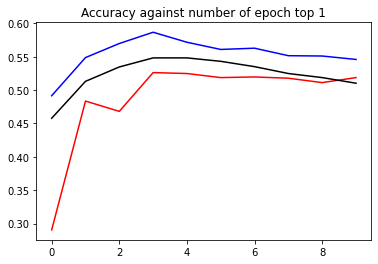

In [ ]:
import matplotlib.pyplot as plt

plt.title("Accuracy against number of epoch top 1")
plt.plot([i for i in range(EPOCH_NUM)], mean_accuracies , label='test 1', color='red')
plt.plot([i for i in range(EPOCH_NUM)], topk_accuracies , label='test 1', color='blue')
plt.plot([i for i in range(EPOCH_NUM)], min_accuracies , label='test 1', color='black')


In [ ]:
print("maximum of min", round(np.max(min_accuracies), 3))
print("maximum of topk", round(np.max(topk_accuracies), 3))
print("maximum of mean", round(np.max(mean_accuracies), 3))


maximum of min 0.548
maximum of topk 0.587
maximum of mean 0.526
